# Simulationg fibrosis

In [1]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import lil_matrix, diags
import sdeint as sde
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5
import diffrax
import jax
from jax import lax
import jax.random as random
from jax.experimental import sparse

In [2]:
def graph_laplacian(N, M, boundary_condition="no-flux", sparse_matrix=True, conduction_block_threshold=0.1):
    """
    Create a graph Laplacian using a 9-point stencil with the option to include conduction blocks.
    Includes support for periodic or von Neumann (no-flux) boundary conditions.
    
    Parameters:
    - boundary_condition: Type of boundary condition ("periodic" or "no-flux").
    - sparse_matrix: Whether to return the Laplacian as a sparse matrix.
    - conduction_block_threshold: Probability threshold for defining conduction blocks. 
      Nodes with random values smaller than this threshold are considered conduction blocks.
    
    """
    
    num_nodes = N * M
    adj_matrix = lil_matrix((num_nodes, num_nodes))  

    # Generate random conduction blocks
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold
    
    def node_index(i, j):
        return i * M + j

    for i in range(N):
        for j in range(M):
            idx = node_index(i, j)
            
            if conduction_blocks[i, j]:
                # Skip this node because it is a conduction block
                continue
            
            #  weights according to Oono-Puri
            neighbors = [
                (i - 1, j, .5),     # up
                (i + 1, j, .5),     # down
                (i, j - 1, .5),     # left
                (i, j + 1, .5),     # right
                (i - 1, j - 1, .25), # top-left
                (i - 1, j + 1, .25), # top-right
                (i + 1, j - 1, .25), # bottom-left
                (i + 1, j + 1, .25)  # bottom-right
            ]
            
            for ni, nj, w in neighbors:
                if boundary_condition == "no-flux":
                    # Apply no-flux (Neumann) boundary conditions:
                    if 0 <= ni < N and 0 <= nj < M:
                        if not conduction_blocks[ni, nj]:
                            # Connect only to non-conduction block neighbors inside the grid
                            adj_matrix[idx, node_index(ni, nj)] = w
                
                elif boundary_condition == "periodic":
                    # Apply periodic boundary conditions by wrapping indices
                    ni_wrapped = ni % N
                    nj_wrapped = nj % M
                    if not conduction_blocks[ni_wrapped, nj_wrapped]:
                        adj_matrix[idx, node_index(ni_wrapped, nj_wrapped)] = w


    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)
    
    laplacian_matrix = degree_matrix - adj_matrix
    
    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix)
    else:
        return jnp.array(laplacian_matrix.todense())
N_x = 200
N_y = 200
N = N_x*N_y
sparse_matrix = True
L1=graph_laplacian(N_x, N_y, boundary_condition="no-flux",sparse_matrix=sparse_matrix, conduction_block_threshold=0)

In [3]:
def FHN_graph(t, y, args):
    N, a, b, e, Du,L= args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) - Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)

In [4]:
@jax.jit
def solve_heart(y0='center-excitation',a=3,b=0.2,e=1e-2,Du=.1,T=300,L=L1, max_steps=1000000, solver=Dopri5(),rtol=1e-3, atol=1e-4,dt0=1e-2):
    if y0 == 'center-excitation':
        y0 = jnp.zeros(2*N)
        center = N//2+N_x//2
        y0 = y0.at[center-1:center+2].set(0.5)
        y0 = y0.at[center-N_x].set(0.5)
        y0 = y0.at[center+N_x].set(0.5)
    
    term = ODETerm(FHN_graph)
    saveat = SaveAt(ts=jnp.linspace(0, T, 100))
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    sol = diffeqsolve(term, solver, 0, T, dt0, y0, args=(N,a,b,e,Du,L), saveat=saveat,max_steps=max_steps, progress_meter=diffrax.TqdmProgressMeter(), stepsize_controller=stepsize_controller)
    return sol

In [5]:
N_x=200
N_y=200
N=N_x*N_y
y0 = np.zeros(2*N)
cells = np.arange(0,N*2,1)
for i in range(N):
    if i%N_x==0:
        y0[i]=0.4

100.00%|██████████| [00:32<00:00,  3.12%/s]


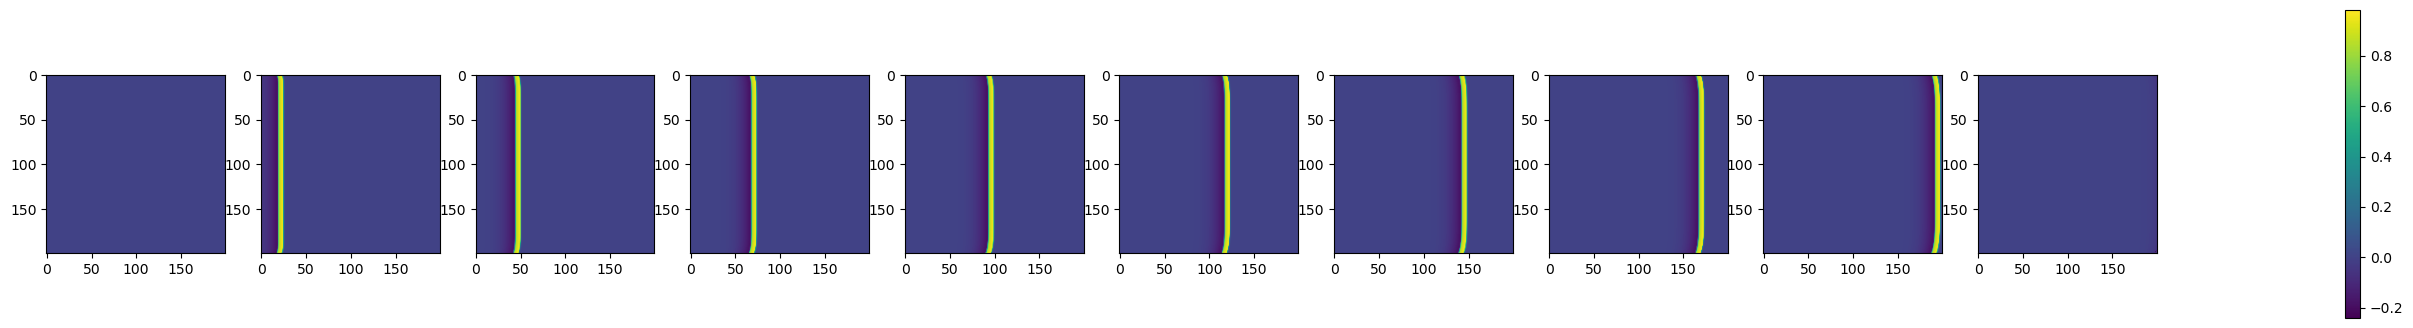

In [6]:
#First simulation without any conduction blockages
sol = solve_heart(y0=y0,T=1900)
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

In [7]:
u_sol = sol.ys[:,:N].T 
v_sol = sol.ys[:,N:].T 


4.8318987e-07


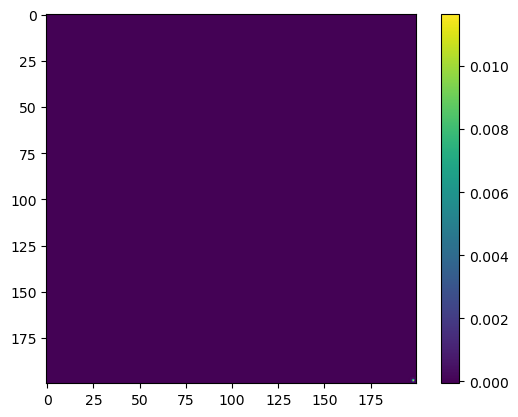

In [8]:
plt.imshow(u_sol[:,-1].reshape(N_x,N_y))
plt.colorbar()
f=u_sol[:,-1]
print(np.mean(np.abs(f)))

All actvity disappears after T=1800 when there are no conduction blockages

In [9]:
#simulation with conduction blockages generating reentry
L1=graph_laplacian(N_x, N_y, boundary_condition="no-flux",sparse_matrix=True, conduction_block_threshold=0.12)


100.00%|██████████| [01:21<00:00,  1.23%/s]


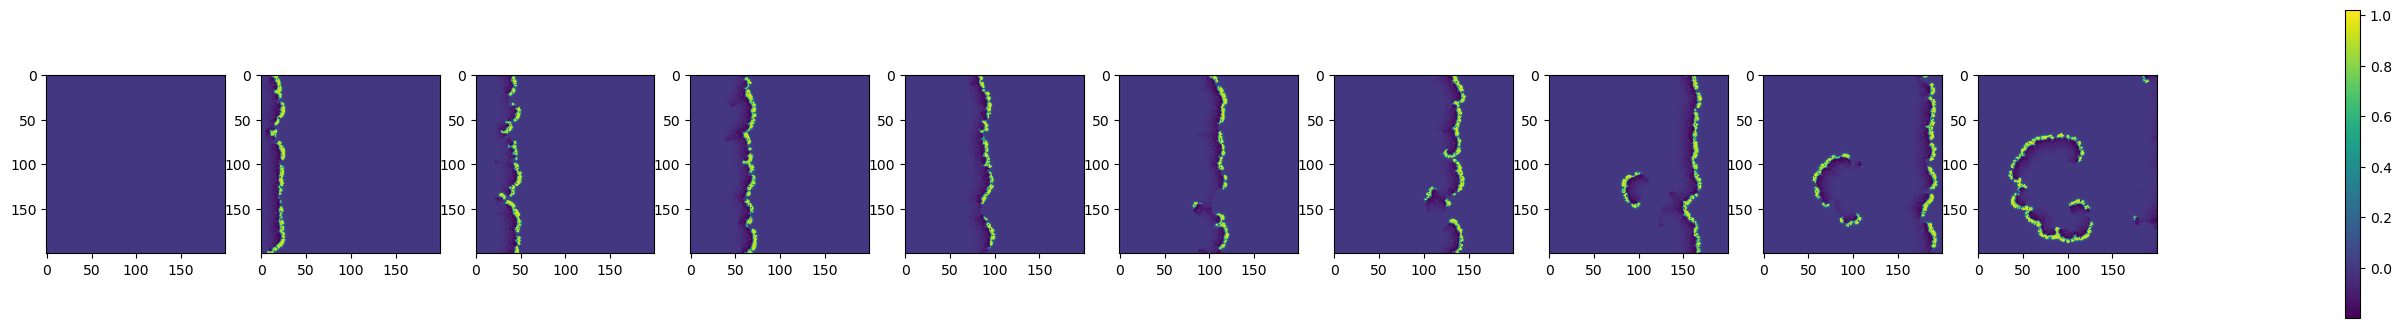

In [10]:
sol = solve_heart(y0=y0,T=2500, L=L1)
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

0.05760207


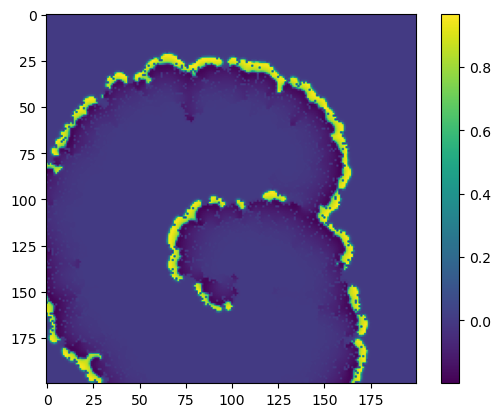

In [11]:
u_sol = sol.ys[:,:N].T 
v_sol = sol.ys[:,N:].T 
plt.imshow(u_sol[:,-1].reshape(N_x,N_y))
plt.colorbar()
f=u_sol[:,-1]
print(np.mean(np.abs(f)))

I get reentry for values in between 1 and 2 approximately (I need to explore the range more systematically and average over multiple simulations). Reentry means that I get sustained activity in the frame even when the wave without any obstacles would have arrived on the other side of the frame (But I need to be careful with this because including some obstacles the wave slows down).

# Several trials
We make 50 different realisations of a given percentage of conduction blocks and calculate the average of u at the last frame to check in how many cases activity persists. I will need to define a threshold for activity and do it for different percentages of blokages.

In [11]:
# brutal python implementation
def activity(threshold):
    L1 = graph_laplacian(N_x, N_y, boundary_condition="no-flux", sparse_matrix=True, conduction_block_threshold=threshold)
    
    sol = solve_heart(y0=y0, T=2100, L=L1)
    
    u_sol = sol.ys[:, :N].T
    f = u_sol[:, -1]

    # Compute the mean of the absolute values 
    avg_val = np.mean(np.abs(f))
    return avg_val

    

In [14]:
#to get some statistics I will need to do simulations for each threshold several times
avg_013=[]
for j in range(32):
    avg_013.append(activity(0.13))
print(avg_013)

100.00%|██████████| [00:58<00:00,  1.72%/s]
100.00%|██████████| [01:01<00:00,  1.63%/s]
100.00%|██████████| [00:55<00:00,  1.79%/s]
100.00%|██████████| [00:49<00:00,  2.00%/s]
100.00%|██████████| [00:44<00:00,  2.25%/s]
100.00%|██████████| [00:43<00:00,  2.29%/s]
100.00%|██████████| [00:38<00:00,  2.57%/s]
100.00%|██████████| [00:41<00:00,  2.40%/s]
100.00%|██████████| [00:42<00:00,  2.38%/s]
100.00%|██████████| [00:45<00:00,  2.21%/s]
100.00%|██████████| [00:45<00:00,  2.21%/s]
100.00%|██████████| [00:45<00:00,  2.22%/s]
100.00%|██████████| [00:56<00:00,  1.78%/s]
100.00%|██████████| [01:14<00:00,  1.34%/s]
100.00%|██████████| [00:57<00:00,  1.74%/s]
100.00%|██████████| [00:59<00:00,  1.67%/s]
100.00%|██████████| [01:08<00:00,  1.47%/s]
100.00%|██████████| [01:05<00:00,  1.52%/s]
100.00%|██████████| [01:21<00:00,  1.23%/s]
100.00%|██████████| [00:57<00:00,  1.74%/s]
100.00%|██████████| [01:03<00:00,  1.57%/s]
100.00%|██████████| [01:09<00:00,  1.44%/s]
100.00%|██████████| [01:00<00:00

[0.054627832, 0.059101366, 0.04774385, 0.09082354, 0.07799858, 0.06971486, 0.07947786, 0.10238736, 0.06865271, 0.08146329, 0.065746985, 0.06471195, 0.06196318, 0.033513237, 0.055288002, 0.04357743, 0.057794884, 0.062255867, 0.033758204, 0.070224926, 0.059284765, 0.04091173, 0.0562218, 0.08376995, 0.0056283814, 0.05493775, 0.0684601, 0.036326207, 0.03303056, 0.058228362, 0.07262137, 0.0013646766]


In [ ]:
#to get some statistics I will need to do simulations for each threshold several times
avg_0=[]
for j in range(32):
    avg_0.append(activity(0))
print(avg_0)

In [ ]:
avg_001=[]
for j in range(32):
    avg_001.append(activity(0.01))
print(avg_001)

14.03%|█▍        | [00:06<00:36,  2.36%/s]

In [ ]:

# JAX implementation: at the moment it doesn't seem to work as the L1 matrix isn't changed at each iteration.
for i in range(2):
    L.append(graph_laplacian(N_x, N_y, boundary_condition="no-flux",sparse_matrix=sparse_matrix, conduction_block_threshold=0.13))
def loop_body(i, avg_01, conduction_block):
    # Generate the graph Laplacian for this iteration
    L1 =graph_laplacian(N_x, N_y, boundary_condition="no-flux",sparse_matrix=sparse_matrix, conduction_block_threshold=0.13)
    
    # Solve the heart simulation
    sol = solve_heart(y0=y0, T=2100, L=L1)
    
    # Extract the solution matrix and get the final time step
    u_sol = sol.ys[:, :N].T
    f = u_sol[:, -1]
    
    # Compute the mean of the absolute values of f
    avg_val = jnp.mean(jnp.abs(f))
    
    # Append the result to the list
    avg_01 = avg_01.at[i].set(avg_val)
    
    return avg_01

# Define a function that handles the entire simulation with the conduction_block parameter
def run_simulation(conduction_block):
    # Initialize an array to store the results
    avg_01 = jnp.zeros(2)

    # Use a JAX-compatible loop with `lax.fori_loop`
    avg_01 = lax.fori_loop(0, 2, lambda i, avg_01: loop_body(i, avg_01, conduction_block), avg_01)

    return avg_01


conduction_block = 0.13
avg_03_results = run_simulation(conduction_block)

# Print the result
print(avg_03_results)


In [7]:
print(avg_02_results) #values fot threashold 0.12

[0.07131948 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948
 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948
 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948
 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948
 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948 0.07131948
 0.07131948 0.07131948]


In [8]:
print(avg_01) #values for threshold 0.1

[2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05
 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05
 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05
 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05
 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05 2.423039e-05]


print()